In [1]:
%load_ext autoreload
%autoreload 1

In [68]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import pickle
from sklearn.dummy import DummyClassifier

In [3]:
import sys
sys.path.append('../../src')
from data import fetch_model_data
from model import evaluation
%aimport data.fetch_model_data
%aimport model.evaluation

Using TensorFlow backend.
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/w

# Model Comparison

In [4]:
metrics=['roc_auc', 'accuracy', 'precision', 'recall']

## Load Data

In [5]:
ip_address = '18.218.116.177'
_, normal_data = fetch_model_data.fetch_model_data(ip_address, split=True)

In [7]:
normal_data = normal_data[normal_data.author_party == 1]

In [16]:
normal_data.third_reading.value_counts()[1] / normal_data.shape[0]

0.8193430656934306

In [8]:
first_feature_set = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
    'ideol_range',
#     'first_word_approp',
]

In [9]:
X, y = normal_data[first_feature_set], normal_data.third_reading
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

## Run Models

In [10]:
models = [
    ('dummy', {}, DummyClassifier),
    ('knn', { 'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}, KNeighborsClassifier),
    ('log', { 'C': [x/10 for x in range(1, 11)], 'penalty': ['l1', 'l2']}, LogisticRegression),
    ('bNB', {}, BernoulliNB),
    ('rf', {
        'n_estimators': [10, 20, 50, 100],
        'max_depth': range(3, 20),
        'min_samples_leaf': range(2, 25)
    }, RandomForestClassifier),
    ('svm', {
#         'penalty': ['l1', 'l2'],
#         'loss': ['hinged', 'squared_hinge'],
        'C': [x/10 for x in range(1, 11)],
        'random_state': [99]
    }, LinearSVC),
    ('dt', { 'max_depth': range(3, 20), 'min_samples_leaf': range(2, 15) }, DecisionTreeClassifier),
    ('stupid_dt', {'max_depth': [2, 5], 'min_samples_leaf': range(10, 20), 'min_impurity_decrease': [0.01]}, DecisionTreeClassifier),
]

In [11]:
%%capture
results, info = evaluation.comparison_pipeline(X_train, y_train, models, metrics)

In [12]:
results['recall'] = [np.mean(x['scores']['test_recall']) for x in info]

In [13]:
results

,roc_auc,accuracy,precision,recall
dummy,0.442723,0.691490,0.816750,0.804851
knn,0.596949,0.819662,0.819662,1.000000
log,0.649429,0.817389,0.822187,0.991667
bNB,0.526335,0.819662,0.819662,1.000000
rf,0.629908,0.819662,0.819662,1.000000
svm,NaN,0.821934,0.824502,0.994444
dt,0.658860,0.803753,0.832422,0.952660
stupid_dt,0.614001,0.821934,0.821543,1.000000


********* dummy **********
********* knn **********
********* log **********


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

********* bNB **********
********* rf **********


../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=80)
../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=80)
../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=80)
../../src/model/evaluation.p

********* svm **********


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=80)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too 

********* dt **********


../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=80)
../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=80)
../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=80)
../../src/model/evaluation.p

********* stupid_dt **********


../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=80)
../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=80)
../../src/model/evaluation.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=80)
../../src/model/evaluation.p

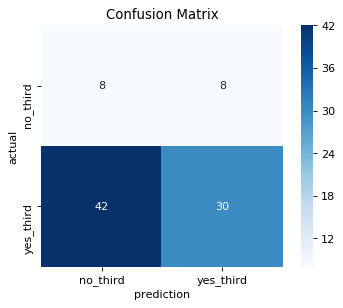

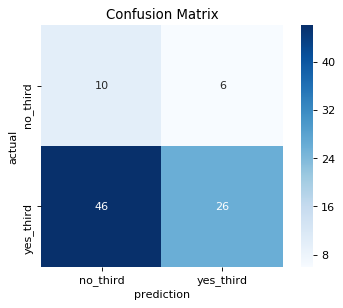

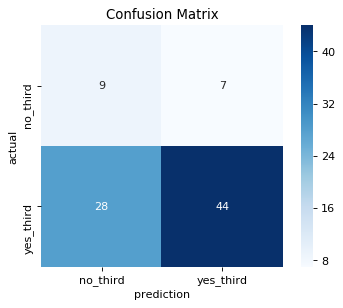

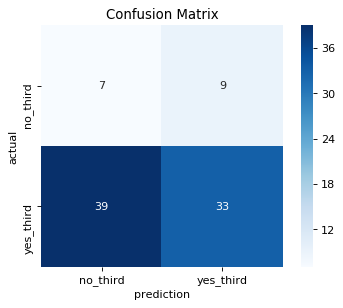

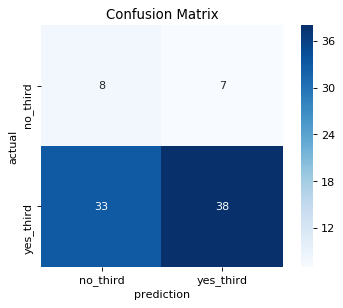

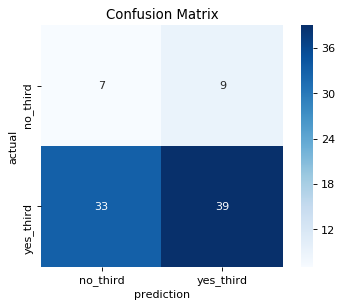

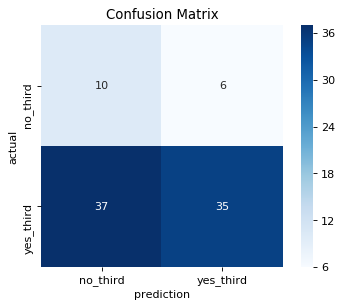

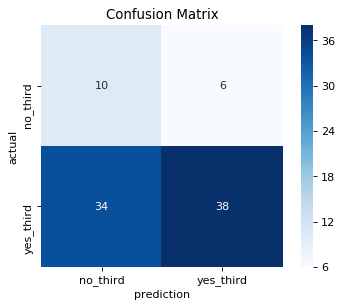

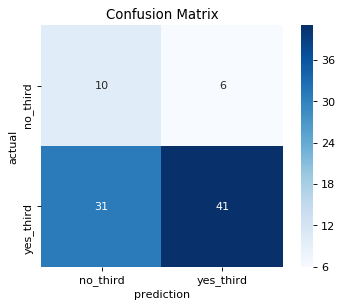

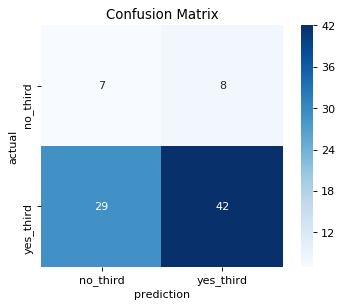

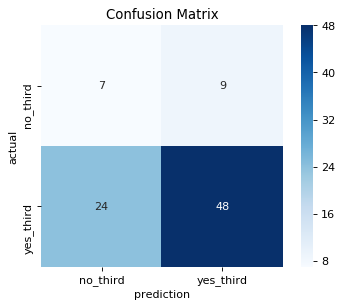

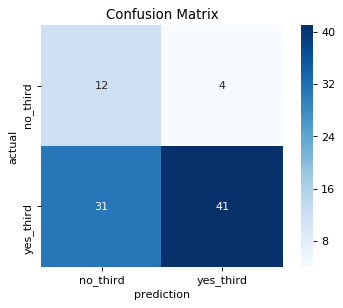

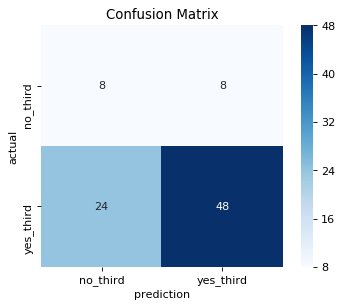

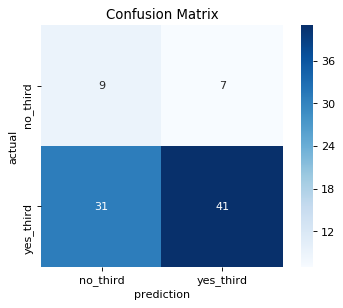

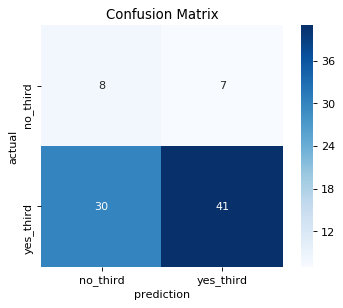

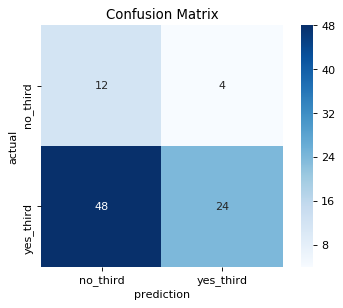

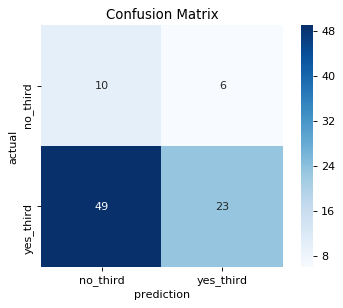

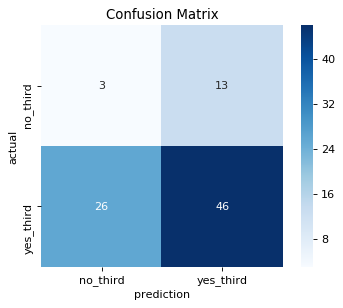

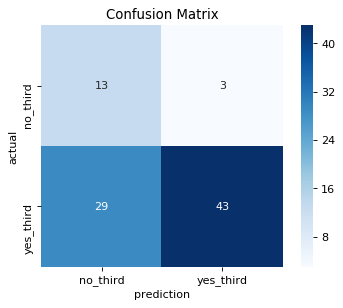

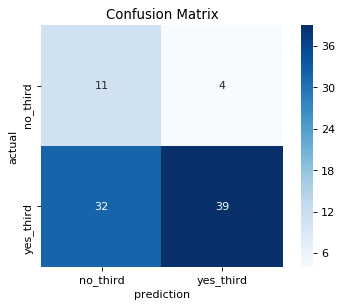

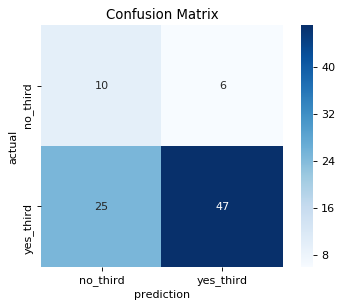

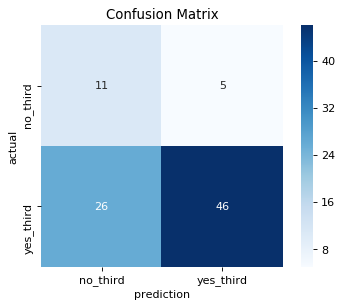

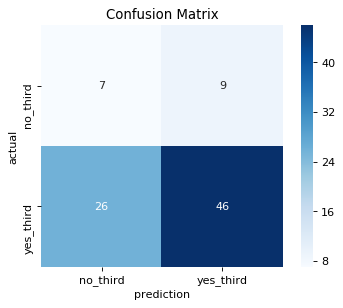

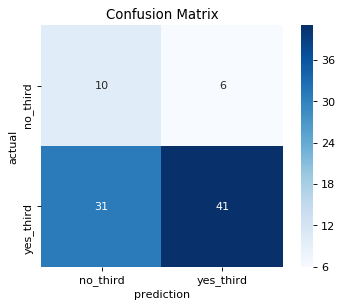

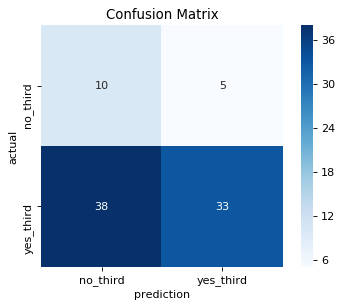

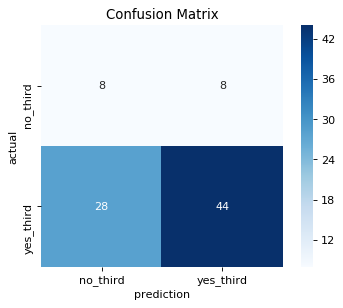

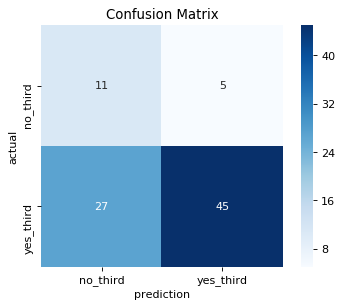

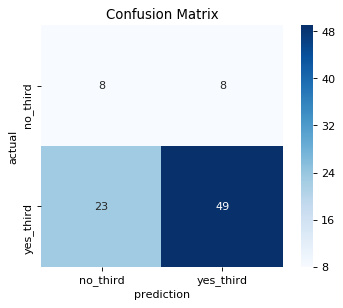

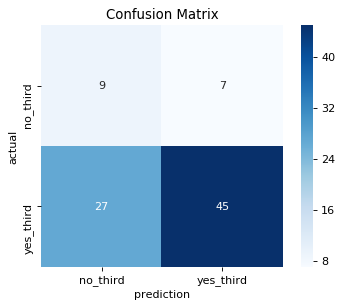

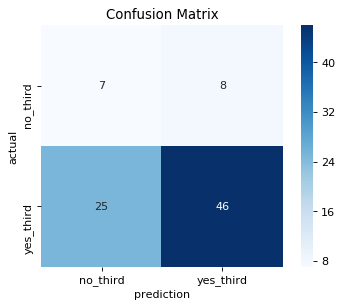

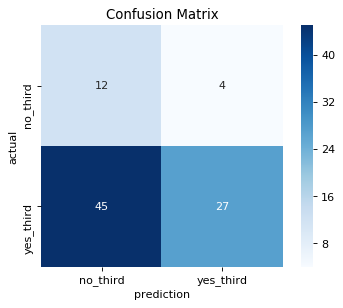

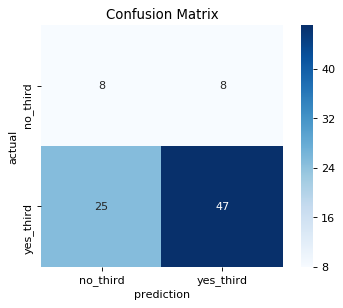

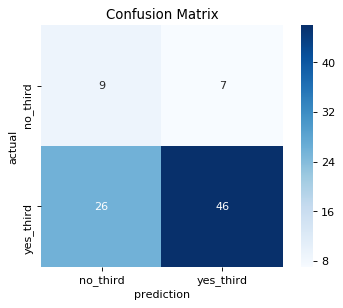

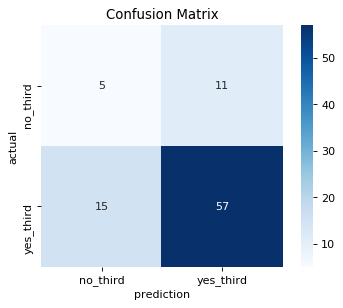

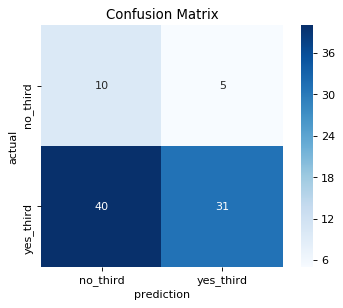

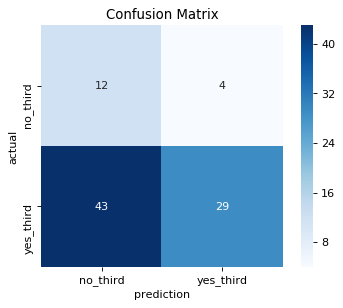

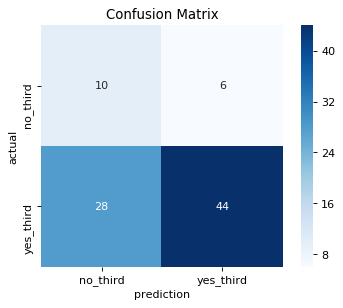

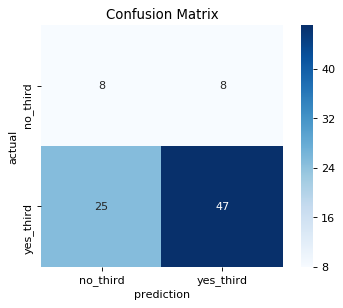

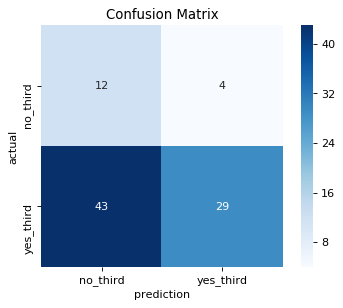

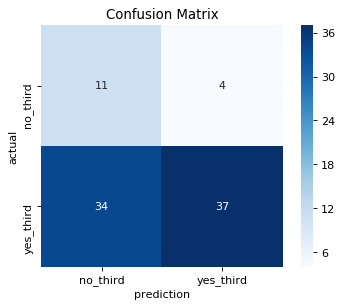

In [20]:
res =[]
for i, model in enumerate(models):
    print('*********', model[0], '**********')
    best_params = info[i]['best_params']
    scores = evaluation.cross_validate(
        model[2],
        X_train,
        y_train,
        fit_params=best_params,
        scoring=metrics,
        standardize=True if model[0] in ['knn', 'log', 'svm'] else False,
        oversample=True,
#         show_conf_matrices=True
    )
    res.append((model[0], scores))

In [23]:
for n, s in res:
    print(n)
    print(evaluation.report_single_model_metrics(s, metrics=metrics))

dummy
      metric      mean       std  in_sample
0    roc_auc  0.436637  0.087194   0.501042
1   accuracy  0.486522  0.071760   0.494062
2  precision  0.818976  0.030276   0.494359
3     recall  0.476487  0.088082   0.483273
knn
      metric      mean       std  in_sample
0    roc_auc  0.550013  0.039973   0.745455
1   accuracy  0.545772  0.026197   0.674428
2  precision  0.848427  0.020939   0.718354
3     recall  0.543310  0.036127   0.579363
log
      metric      mean       std  in_sample
0    roc_auc  0.638591  0.036336   0.705024
1   accuracy  0.600317  0.027851   0.630912
2  precision  0.863739  0.024244   0.627928
3     recall  0.609937  0.046412   0.644841
bNB
      metric      mean       std  in_sample
0    roc_auc  0.560197  0.110273   0.615547
1   accuracy  0.511734  0.101636   0.584598
2  precision  0.854333  0.060953   0.608894
3     recall  0.487637  0.134749   0.486055
rf
      metric      mean       std  in_sample
0    roc_auc  0.644646  0.055590   0.813239
1   accurac

In [ ]:
# Definitely got better (but not much)

## Random Forest

In [24]:
for i, model in enumerate(models):
    print('*********', model[0], '**********')
    print(info[i]['best_params'])

********* dummy **********
{}
********* knn **********
{'n_neighbors': 19, 'weights': 'uniform'}
********* log **********
{'C': 0.1, 'penalty': 'l2'}
********* bNB **********
{}
********* rf **********
{'max_depth': 3, 'min_samples_leaf': 21, 'n_estimators': 10}
********* svm **********
{'C': 0.3, 'random_state': 99}
********* dt **********
{'max_depth': 3, 'min_samples_leaf': 6}
********* stupid_dt **********
{'max_depth': 2, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 16}


In [169]:
scores_rf = evaluation.cross_validate(
    RandomForestClassifier,
    X_train,
    y_train,
    fit_params={'max_depth': 3, 'min_samples_leaf': 40, 'n_estimators': 10},
    scoring=metrics,
#     standardize=False,
    oversample=True,
#     show_conf_matrices=True,
    threshold=.6
)
evaluation.report_single_model_metrics(scores_rf, metrics=metrics)

,metric,mean,std,in_sample
0,roc_auc,0.578353,0.057802,0.777572
1,accuracy,0.410624,0.053038,0.650064
2,precision,0.896238,0.056245,0.839928
3,recall,0.320110,0.071138,0.372573


## Logistic Regression

In [168]:
scores_rf = evaluation.cross_validate(
    LogisticRegression,
    X_train,
    y_train,
    fit_params={'C': 0.2, 'penalty': 'l2'},
    scoring=metrics,
    standardize=True,
    std_features=[
        'author_ideology',
        'author_years_sen',
        'author_total_funding',
        'total_sponsors',
        'sponsor_chairs',
        'agg_funding_sponsors',
        'agg_exp_sponsors',
        'total_slips',
        'slips_perc_pro',
        'ideol_range',
    ],
    oversample=True,
#     show_conf_matrices=True,
    threshold=.65
)
evaluation.report_single_model_metrics(scores_rf, metrics=metrics)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

,metric,mean,std,in_sample
0,roc_auc,0.629123,0.055812,0.703940
1,accuracy,0.360412,0.045397,0.605502
2,precision,0.892872,0.049555,0.836615
3,recall,0.250509,0.059640,0.263240


# Partial Models

## Hearing Features

In [243]:
scores_rf = evaluation.cross_validate(
    RandomForestClassifier,
    X_train[[
#         'author_ideology',
#         'author_party',
#         'author_is_chair',
#         'author_years_sen',
#         'author_total_funding',
#         'total_sponsors',
#         'sponsor_chairs',
#         'agg_funding_sponsors',
#         'agg_exp_sponsors',
        'total_slips',
        'slips_perc_pro',
#         'bipartisan',
#         'ideol_range',
    ]],
    y_train,
    fit_params={'max_depth': 3, 'min_samples_leaf': 40, 'n_estimators': 10, 'random_state': 42},
    scoring=metrics,
#     standardize=False,
    oversample=True,
#     show_conf_matrices=True,
    threshold=.6
)
evaluation.report_single_model_metrics(scores_rf, metrics=metrics)

,metric,mean,std,in_sample
0,roc_auc,0.665104,0.073187,0.722276
1,accuracy,0.467706,0.059141,0.631623
2,precision,0.915918,0.038453,0.730512
3,recall,0.386894,0.072560,0.417155


In [190]:
X_train.author_party.value_counts()

1    438
Name: author_party, dtype: int64

In [238]:
with_extra = X_train.copy()
with_extra['net_pro'] = (with_extra.slips_perc_pro * with_extra.total_slips) - ((1-with_extra.slips_perc_pro) * with_extra.total_slips)
with_extra['unanimous_slips'] = with_extra.slips_perc_pro.map(lambda x: 1 if x > 0 else 0)
with_extra['risk_tolerance'] = (with_extra.author_years_sen + 1) * (with_extra.author_is_chair + 1)

for features in [['total_slips'], ['net_pro'], ['total_slips', 'slips_perc_pro'], ['total_slips', 'net_pro']]:
    print(features)
    scores_rf = evaluation.cross_validate(
        RandomForestClassifier,
        with_extra[features],
        y_train,
        fit_params={'max_depth': 3, 'min_samples_leaf': 40, 'n_estimators': 10, 'random_state': 42},
        scoring=metrics,
    #     standardize=False,
        oversample=True,
#         show_conf_matrices=True,
        threshold=.66
    )
    print(evaluation.report_single_model_metrics(scores_rf, metrics=metrics))

['total_slips']
      metric      mean       std  in_sample
0    roc_auc  0.655917  0.044213   0.692731
1   accuracy  0.365433  0.033581   0.592264
2  precision  0.931923  0.056154   0.746576
3     recall  0.245188  0.047307   0.279905
['net_pro']


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      metric      mean       std  in_sample
0    roc_auc  0.563270  0.072517   0.656019
1   accuracy  0.235042  0.093315   0.533050
2  precision  0.302857  0.371912   0.295958
3     recall  0.091862  0.150997   0.110668
['total_slips', 'slips_perc_pro']
      metric      mean       std  in_sample
0    roc_auc  0.665104  0.073187   0.722276
1   accuracy  0.387896  0.041790   0.598196
2  precision  0.923400  0.063349   0.747112
3     recall  0.281103  0.066431   0.298771
['total_slips', 'net_pro']
      metric      mean       std  in_sample
0    roc_auc  0.660661  0.057456   0.719033
1   accuracy  0.399313  0.033484   0.594708
2  precision  0.942063  0.048119   0.761399
3     recall  0.286698  0.044301   0.279247


In [241]:
%%capture
results, info = evaluation.comparison_pipeline(
    X_train[['total_slips', 'slips_perc_pro']],
    y_train,
    models,
    metrics,
    oversample=True
)

In [242]:
results['recall'] = [np.mean(x['scores']['test_recall']) for x in info]
results

,roc_auc,accuracy,precision,recall
dummy,0.557293,0.493023,0.814716,0.492919
knn,0.573514,0.591279,0.847758,0.612715
log,0.624297,0.661892,0.853653,0.710094
bNB,0.507028,0.346723,0.844171,0.261502
rf,0.635228,0.700846,0.877140,0.740767
svm,NaN,0.668710,0.854839,0.718427
dt,0.590351,0.659778,0.848480,0.712989
stupid_dt,0.628527,0.613953,0.884339,0.612598


**Conclusion** -> use this model as an input or in a stacked approach

## Author Features

In [255]:
%%capture
with_extra = X_train.copy()
with_extra['author_very_liberal'] = with_extra.author_ideology.map(lambda x: 1 if x < -1 else 0)
with_extra['author_term'] = with_extra.author_years_sen.map(lambda x: 3 if (np.floor(x / 5) + 1) > 3 else np.floor(x / 5) + 1)
with_extra['author_funding_level'] = with_extra.author_total_funding.map(lambda x: 0 if x < 400000 else 1 if x < 1000000 else 2)

results, info = evaluation.comparison_pipeline(
    with_extra[[
#         'author_ideology',
        'author_is_chair',
#         'author_years_sen',
#         'author_total_funding',
        'author_very_liberal',
        'author_term',
        'author_funding_level'
    ]],
    y_train,
    models,
    metrics,
    oversample=True
)

In [256]:
results['recall'] = [np.mean(x['scores']['test_recall']) for x in info]
results

,roc_auc,accuracy,precision,recall
dummy,0.502649,0.504968,0.824167,0.501643
knn,0.552875,0.588742,0.826882,0.634859
log,0.622658,0.607241,0.860573,0.626839
bNB,0.614589,0.467865,0.889542,0.401017
rf,0.597389,0.529810,0.868913,0.504382
svm,NaN,0.639535,0.868317,0.666080
dt,0.591302,0.472252,0.875777,0.414789
stupid_dt,0.525538,0.532928,0.843092,0.539202


In [269]:
info[2]['best_params']

{'C': 1.0, 'penalty': 'l2'}

In [270]:
for c in [x/10 for x in range(1, 11)]:
    print('********', c)
    scores_rf = evaluation.cross_validate(
        LogisticRegression,
        with_extra[[
    #         'author_ideology',
            'author_is_chair',
    #         'author_years_sen',
    #         'author_total_funding',
    #         'author_very_liberal',
            'author_term',
            'author_funding_level'
        ]],
        y_train,
        fit_params={'C': c, 'penalty': 'l2'},
        scoring=metrics,
        standardize=False,
        std_features=[
            'author_ideology',
    #         'author_years_sen',
    #         'author_total_funding'
        ],
        oversample=True,
    #     show_conf_matrices=True,
        threshold=.5
    )
    print(evaluation.report_single_model_metrics(scores_rf, metrics=metrics))

******** 0.1
      metric      mean       std  in_sample
0    roc_auc  0.629413  0.079218   0.637262
1   accuracy  0.557188  0.061547   0.589141
2  precision  0.883656  0.049232   0.608999
3     recall  0.534977  0.097369   0.516703
******** 0.2
      metric      mean       std  in_sample
0    roc_auc  0.630802  0.077544   0.637561
1   accuracy  0.541279  0.079761   0.598897
2  precision  0.885580  0.048485   0.629580
3     recall  0.512754  0.125036   0.501372
******** 0.3
      metric      mean       std  in_sample
0    roc_auc  0.637747  0.087028   0.639416
1   accuracy  0.485888  0.101906   0.605149
2  precision  0.887552  0.045279   0.679838
3     recall  0.428678  0.141070   0.427623
******** 0.4


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

      metric      mean       std  in_sample
0    roc_auc  0.637747  0.087028   0.639416
1   accuracy  0.485888  0.101906   0.605846
2  precision  0.887552  0.045279   0.679570
3     recall  0.428678  0.141070   0.433895
******** 0.5
      metric      mean       std  in_sample
0    roc_auc  0.643129  0.081410   0.642929
1   accuracy  0.494979  0.097600   0.609679
2  precision  0.882454  0.038091   0.678633
3     recall  0.442567  0.131348   0.450619
******** 0.6
      metric      mean       std  in_sample
0    roc_auc  0.650991  0.072834   0.646436
1   accuracy  0.494979  0.097600   0.609679
2  precision  0.882454  0.038091   0.678633
3     recall  0.442567  0.131348   0.450619
******** 0.7
      metric      mean       std  in_sample
0    roc_auc  0.652727  0.070351   0.645596
1   accuracy  0.504070  0.091075   0.613163
2  precision  0.886376  0.033574   0.672665
3     recall  0.453678  0.125010   0.468041
******** 0.8


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

      metric      mean       std  in_sample
0    roc_auc  0.652727  0.070351   0.645596
1   accuracy  0.504070  0.091075   0.613163
2  precision  0.886376  0.033574   0.672665
3     recall  0.453678  0.125010   0.468041
******** 0.9
      metric      mean       std  in_sample
0    roc_auc  0.652727  0.070351   0.645596
1   accuracy  0.515433  0.087668   0.611421
2  precision  0.890147  0.030528   0.666884
3     recall  0.467567  0.122414   0.470828
******** 1.0
      metric      mean       std  in_sample
0    roc_auc  0.651512  0.070609   0.644787
1   accuracy  0.515433  0.087668   0.611421
2  precision  0.890147  0.030528   0.666884
3     recall  0.467567  0.122414   0.470828


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

,metric,mean,std,in_sample
0,roc_auc,0.652727,0.070351,0.645596
1,accuracy,0.515433,0.087668,0.611421
2,precision,0.890147,0.030528,0.666884
3,recall,0.467567,0.122414,0.470828


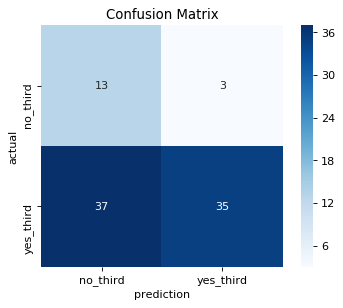

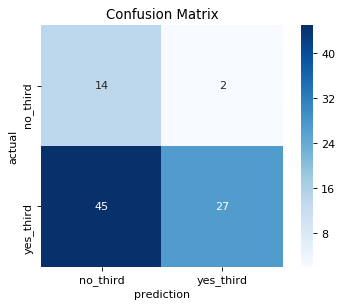

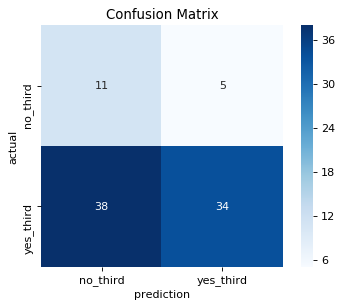

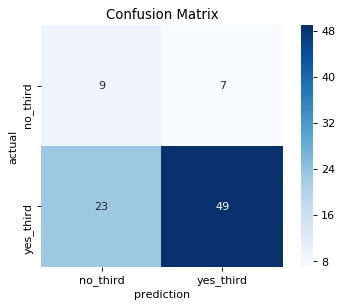

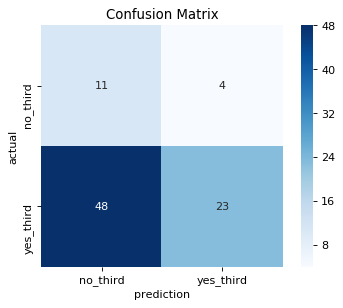

In [279]:
scores_rf = evaluation.cross_validate(
    LogisticRegression,
    with_extra[[
#         'author_ideology',
        'author_is_chair',
#         'author_years_sen',
#         'author_total_funding',
#         'author_very_liberal',
        'author_term',
        'author_funding_level',
    ]],
    y_train,
    fit_params={'C': 0.9, 'penalty': 'l2'},
    scoring=metrics,
    standardize=False,
    std_features=[
        'author_ideology',
#         'author_years_sen',
#         'author_total_funding'
    ],
    oversample=True,
    show_conf_matrices=True,
    threshold=.5
)
evaluation.report_single_model_metrics(scores_rf, metrics=metrics)

## Congressional Support Model

In [280]:
%%capture
with_extra = X_train.copy()
with_extra['author_very_liberal'] = with_extra.author_ideology.map(lambda x: 1 if x < -1 else 0)
with_extra['author_term'] = with_extra.author_years_sen.map(lambda x: 3 if (np.floor(x / 5) + 1) > 3 else np.floor(x / 5) + 1)
with_extra['author_funding_level'] = with_extra.author_total_funding.map(lambda x: 0 if x < 400000 else 1 if x < 1000000 else 2)

results, info = evaluation.comparison_pipeline(
    with_extra[[
        'total_sponsors',
        'sponsor_chairs',
        'agg_funding_sponsors',
        'agg_exp_sponsors',
        'bipartisan',
        'ideol_range',
    ]],
    y_train,
    models,
    metrics,
    oversample=True,
    std_features=[
        'total_sponsors',
        'sponsor_chairs',
        'agg_funding_sponsors',
        'agg_exp_sponsors',
#         'bipartisan',
        'ideol_range',
    ]
)

In [281]:
results['recall'] = [np.mean(x['scores']['test_recall']) for x in info]
results

,roc_auc,accuracy,precision,recall
dummy,0.499849,0.490592,0.798633,0.503991
knn,0.491413,0.543182,0.805657,0.576369
log,0.521089,0.675846,0.831790,0.757707
bNB,0.461978,0.531712,0.793358,0.579069
rf,0.492101,0.591913,0.814234,0.652387
svm,NaN,0.677960,0.836705,0.754773
dt,0.457260,0.543869,0.795260,0.591041
stupid_dt,0.469776,0.461945,0.478333,0.457590


In [284]:
info[2]['best_params']

{'C': 0.5, 'penalty': 'l1'}

In [307]:
for c in [x/10 for x in range(1, 11)]:
    for p in ['l1', 'l2']:
        print('********', c, p)
        scores_rf = evaluation.cross_validate(
            LogisticRegression,
            with_extra[[
                'total_sponsors',
        #         'sponsor_chairs',
        #         'agg_funding_sponsors',
        #         'agg_exp_sponsors',
                'bipartisan',
        #         'ideol_range',
            ]],
            y_train,
            fit_params={'C': c, 'penalty': p},
            scoring=metrics,
            standardize=False,
            std_features=[
                'total_sponsors',
                'sponsor_chairs',
                'agg_funding_sponsors',
                'agg_exp_sponsors',
        #         'bipartisan',
                'ideol_range',
            ],
            oversample=True,
        #     show_conf_matrices=True,
            threshold=.5
        )
        print(evaluation.report_single_model_metrics(scores_rf, metrics=metrics))

******** 0.1 l1
      metric      mean       std  in_sample
0    roc_auc  0.529546  0.096482   0.551763
1   accuracy  0.347992  0.154937   0.533775
2  precision  0.680074  0.349503   0.503525
3     recall  0.268271  0.257319   0.295035
******** 0.1 l2
      metric      mean       std  in_sample
0    roc_auc  0.555168  0.070599   0.568608
1   accuracy  0.693975  0.023123   0.561287
2  precision  0.833502  0.027592   0.542927
3     recall  0.785485  0.035956   0.778523
******** 0.2 l1
      metric      mean       std  in_sample
0    roc_auc  0.550357  0.068477   0.569811
1   accuracy  0.468816  0.154739   0.548401
2  precision  0.846279  0.081256   0.591511
3     recall  0.449100  0.251886   0.460826
******** 0.2 l2


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site

      metric      mean       std  in_sample
0    roc_auc  0.562602  0.063704   0.567301
1   accuracy  0.653118  0.039117   0.546304
2  precision  0.834213  0.025839   0.533715
3     recall  0.724413  0.087137   0.706746
******** 0.3 l1
      metric      mean       std  in_sample
0    roc_auc  0.552043  0.058669   0.568289
1   accuracy  0.602960  0.042058   0.545613
2  precision  0.830684  0.029283   0.537918
3     recall  0.649139  0.061141   0.639203
******** 0.3 l2
      metric      mean       std  in_sample
0    roc_auc  0.562081  0.063138   0.567569
1   accuracy  0.623573  0.058999   0.544562
2  precision  0.823779  0.025010   0.535156
3     recall  0.691080  0.106101   0.669115
******** 0.4 l1


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

      metric      mean       std  in_sample
0    roc_auc  0.555484  0.057732   0.569351
1   accuracy  0.605285  0.044886   0.545613
2  precision  0.831168  0.029774   0.537804
3     recall  0.651956  0.063253   0.641294
******** 0.4 l2
      metric      mean       std  in_sample
0    roc_auc  0.562818  0.063569   0.567704
1   accuracy  0.623573  0.058999   0.544911
2  precision  0.823779  0.025010   0.535442
3     recall  0.691080  0.106101   0.671898
******** 0.5 l1
      metric      mean       std  in_sample
0    roc_auc  0.555484  0.057732   0.569351
1   accuracy  0.605285  0.044886   0.545962
2  precision  0.831168  0.029774   0.538119
3     recall  0.651956  0.063253   0.641991
******** 0.5 l2


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

      metric      mean       std  in_sample
0    roc_auc  0.556395  0.057556   0.568304
1   accuracy  0.614482  0.050457   0.547699
2  precision  0.824665  0.025365   0.538593
3     recall  0.674413  0.082329   0.659354
******** 0.6 l1
      metric      mean       std  in_sample
0    roc_auc  0.555484  0.057732   0.569351
1   accuracy  0.607558  0.043799   0.546310
2  precision  0.831739  0.030290   0.538419
3     recall  0.654734  0.060420   0.642688
******** 0.6 l2
      metric      mean       std  in_sample
0    roc_auc  0.556395  0.057556   0.568304
1   accuracy  0.614482  0.050457   0.548047
2  precision  0.824665  0.025365   0.538907
3     recall  0.674413  0.082329   0.660051
******** 0.7 l1
      metric      mean       std  in_sample
0    roc_auc  0.556395  0.057556   0.568984
1   accuracy  0.607558  0.043799   0.546310
2  precision  0.831739  0.030290   0.538419
3     recall  0.654734  0.060420   0.642688
******** 0.7 l2


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

      metric      mean       std  in_sample
0    roc_auc  0.556395  0.057556   0.568984
1   accuracy  0.609831  0.044347   0.546311
2  precision  0.832373  0.029386   0.538324
3     recall  0.657512  0.063689   0.644774
******** 0.8 l1
      metric      mean       std  in_sample
0    roc_auc  0.556395  0.057556   0.568984
1   accuracy  0.609831  0.044347   0.546311
2  precision  0.832373  0.029386   0.538324
3     recall  0.657512  0.063689   0.644774
******** 0.8 l2
      metric      mean       std  in_sample
0    roc_auc  0.556395  0.057556   0.568984
1   accuracy  0.609831  0.044347   0.546311
2  precision  0.832373  0.029386   0.538324
3     recall  0.657512  0.063689   0.644774
******** 0.9 l1


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

      metric      mean       std  in_sample
0    roc_auc  0.557089  0.058291   0.569353
1   accuracy  0.609831  0.044347   0.546311
2  precision  0.832373  0.029386   0.538324
3     recall  0.657512  0.063689   0.644774
******** 0.9 l2
      metric      mean       std  in_sample
0    roc_auc  0.556395  0.057556   0.568984
1   accuracy  0.609831  0.044347   0.546311
2  precision  0.832373  0.029386   0.538324
3     recall  0.657512  0.063689   0.644774
******** 1.0 l1
      metric      mean       std  in_sample
0    roc_auc  0.557089  0.058291   0.569353
1   accuracy  0.609831  0.044347   0.546311
2  precision  0.832373  0.029386   0.538324
3     recall  0.657512  0.063689   0.644774
******** 1.0 l2


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

      metric      mean       std  in_sample
0    roc_auc  0.556395  0.057556   0.568984
1   accuracy  0.609831  0.044347   0.546311
2  precision  0.832373  0.029386   0.538324
3     recall  0.657512  0.063689   0.644774


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [308]:
leg_log_params = { 'C': 0.4, 'penalty': 'l2' }

In [311]:
scores_rf = evaluation.cross_validate(
    LogisticRegression,
    with_extra[[
        'total_sponsors',
#         'sponsor_chairs',
#         'agg_funding_sponsors',
#         'agg_exp_sponsors',
        'bipartisan',
#         'ideol_range',
    ]],
    y_train,
    fit_params=leg_log_params,
    scoring=metrics,
    standardize=False,
    std_features=[
        'total_sponsors',
        'sponsor_chairs',
        'agg_funding_sponsors',
        'agg_exp_sponsors',
#         'bipartisan',
        'ideol_range',
    ],
    oversample=True,
#     show_conf_matrices=True,
    threshold=.6
)
evaluation.report_single_model_metrics(scores_rf, metrics=metrics)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

,metric,mean,std,in_sample
0,roc_auc,0.562818,0.063569,0.567704
1,accuracy,0.241860,0.019192,0.526475
2,precision,0.904762,0.085773,0.680469
3,recall,0.086228,0.023677,0.098214


# With All The Final Features

In [312]:
final_features = [
    'total_sponsors',
    'bipartisan',
    'author_is_chair',
    'author_term',
    'author_funding_level',
    'total_slips',
    'slips_perc_pro',
]

In [313]:
%%capture
with_extra = X_train.copy()
with_extra['author_very_liberal'] = with_extra.author_ideology.map(lambda x: 1 if x < -1 else 0)
with_extra['author_term'] = with_extra.author_years_sen.map(lambda x: 3 if (np.floor(x / 5) + 1) > 3 else np.floor(x / 5) + 1)
with_extra['author_funding_level'] = with_extra.author_total_funding.map(lambda x: 0 if x < 400000 else 1 if x < 1000000 else 2)

results, info = evaluation.comparison_pipeline(
    with_extra[final_features],
    y_train,
    models,
    metrics,
    oversample=True,
    std_features=['total_sponsors', 'total_slips', 'slips_perc_pro']
)

In [314]:
results['recall'] = [np.mean(x['scores']['test_recall']) for x in info]
results

,roc_auc,accuracy,precision,recall
dummy,0.488482,0.481871,0.812886,0.482121
knn,0.562710,0.561416,0.840674,0.576330
log,0.659068,0.618658,0.876275,0.623905
bNB,0.592164,0.515751,0.876603,0.476135
rf,0.628101,0.700846,0.855597,0.765845
svm,NaN,0.616385,0.873179,0.623905
dt,0.610838,0.639112,0.849493,0.682277
stupid_dt,0.619637,0.638478,0.874114,0.662207


In [ ]:
# logistic
# TODO: look at ROC_AUC curve

In [315]:
info[2]['best_params']

{'C': 1.0, 'penalty': 'l2'}

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linea

,metric,mean,std,in_sample
0,roc_auc,0.661279,0.027574,0.703143
1,accuracy,0.458562,0.048271,0.660166
2,precision,0.879124,0.041283,0.803734
3,recall,0.392567,0.044581,0.424107


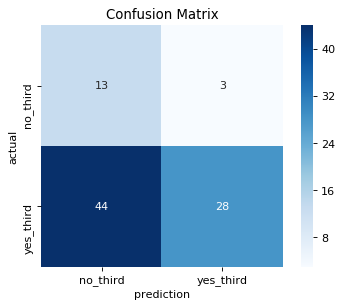

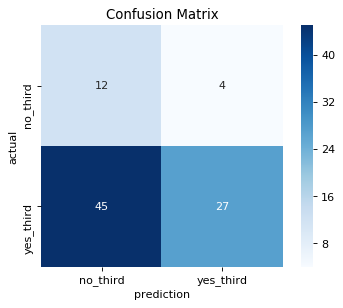

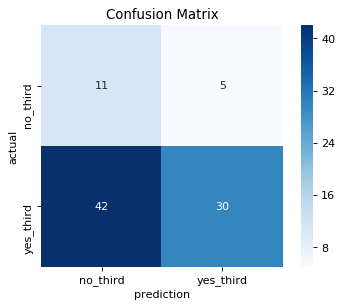

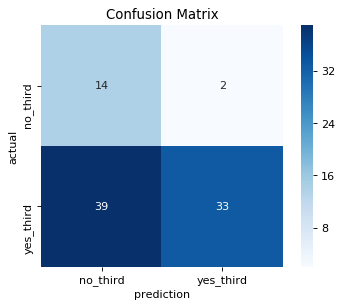

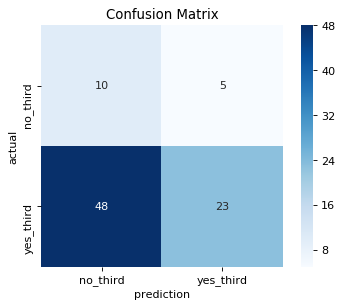

In [336]:
scores_rf = evaluation.cross_validate(
    LogisticRegression,
    with_extra[final_features],
    y_train,
    fit_params={'C': 100.0, 'penalty': 'l2'},
    scoring=metrics,
    standardize=True,
    std_features=['total_sponsors', 'total_slips', 'slips_perc_pro'],
    oversample=True,
    show_conf_matrices=True,
    threshold=.6
)
evaluation.report_single_model_metrics(scores_rf, metrics=metrics)